In [22]:
from utils.dataset import load_dataset
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tsgm
import tensorflow as tf
import numpy as np
dataset_name = "ItalyPowerDemand"
data = load_dataset(dataset_name, "TRAIN")
ts_data = data.iloc[:,1:]
ts_data = ts_data.to_numpy(dtype=np.float32)
org_data_shape = ts_data.shape
N  = org_data_shape[0]
T = org_data_shape[1]

scaler_minmax = True

if scaler_minmax:
    scaler = MinMaxScaler()
    ts_data = scaler.fit_transform(ts_data)
ts_data = ts_data.reshape(N, T, 1)

if not scaler_minmax:
    scaler = tsgm.utils.TSFeatureWiseScaler()
    ts_data = scaler.fit_transform(ts_data)



ts_data.shape


(67, 24, 1)

In [23]:
from sklearn.preprocessing import OneHotEncoder
data = load_dataset(dataset_name, "TRAIN")

# Suppose labels is a 1D array of length N
labels = data.iloc[:, 0].to_numpy()  # shape (N,)
unique_labels = np.unique(labels)
num_classes = len(unique_labels)

enc = OneHotEncoder()
labels = enc.fit_transform(labels.reshape(-1, 1)).toarray()
labels = np.array(labels,dtype=np.float32)
(ny, y) = labels.shape
# Initialize encoder (dense output for simplicity)
labels.shape

(67, 2)

In [24]:
latent_dims = {
    "ItalyPowerDemand": 2,
}


In [25]:

import tsgm
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import binary_crossentropy
from Generators.helperFiles.ConditionalGan import ConditionalGAN
from collections import defaultdict
seq_len = T
feat_dim = 1
laten_dict = defaultdict(lambda : max(8, min(seq_len // 4, 64)))
for d,v in latent_dims.items():
    laten_dict[d] = v

latent_dim = laten_dict[dataset_name]
output_dim = 2 # Binary One Hot Encoded
model_type = tsgm.models.architectures.zoo["cgan_lstm_n"]
arch = model_type(
    seq_len=seq_len, feat_dim=feat_dim,
    latent_dim=latent_dim, output_dim=output_dim)
arch_dict = arch.get()

discriminator, generator = arch_dict["discriminator"], arch_dict["generator"]

print(generator.summary())
print(discriminator.summary())


cGan = ConditionalGAN(discriminator=discriminator,generator=generator,latent_dim=latent_dim,temporal=False)

cGan.compile(d_optimizer=Adam(1e-4,beta_1=0.0,beta_2=0.9),g_optimizer=Adam(5e-4, beta_1=0.0,beta_2=0.9), loss_fn=binary_crossentropy)

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_7 (Dense)             (None, 1536)              7680      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1536)              0         
                                                                 
 reshape_3 (Reshape)         (None, 24, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 24, 256)           328704    
                                                                 
 average_pooling1d_3 (Avera  (None, 24, 256)           0         
 gePooling1D)                                                    
                                                         

In [26]:
cGan.fit(x=ts_data,y=labels, epochs=30, batch_size=6)


Epoch 1/30
12/12 [==============================] - 2s 19ms/step - g_loss: 0.7341 - d_loss: 0.6876
Epoch 2/30
12/12 [==============================] - 0s 20ms/step - g_loss: 0.6999 - d_loss: 0.6977
Epoch 3/30
12/12 [==============================] - 0s 20ms/step - g_loss: 0.7065 - d_loss: 0.6959
Epoch 4/30
12/12 [==============================] - 0s 19ms/step - g_loss: 0.7164 - d_loss: 0.6914
Epoch 5/30
12/12 [==============================] - 0s 19ms/step - g_loss: 0.6965 - d_loss: 0.6960
Epoch 6/30
12/12 [==============================] - 0s 19ms/step - g_loss: 0.6903 - d_loss: 0.6924
Epoch 7/30
12/12 [==============================] - 0s 19ms/step - g_loss: 0.6949 - d_loss: 0.6930
Epoch 8/30
12/12 [==============================] - 0s 19ms/step - g_loss: 0.6918 - d_loss: 0.6932
Epoch 9/30
12/12 [==============================] - 0s 20ms/step - g_loss: 0.6927 - d_loss: 0.6934
Epoch 10/30
12/12 [==============================] - 0s 21ms/step - g_loss: 0.6932 - d_loss: 0.6934
Epoch 11/

In [27]:
nr_samples = 100

num_classes = num_classes
per_class = nr_samples // num_classes

def distribute_items(n, k):
    """Distribute n items across k bags as evenly as possible"""
    return np.array_split(range(n), k)

def distribute_counts(n, k):
    """Get just the counts per bag"""
    return [len(bag) for bag in distribute_items(n, k)]

all_samples = []

for i, samples in enumerate(distribute_counts(nr_samples, num_classes)):
    for _ in range(samples):
        one_hot = [0.0 for _ in range(num_classes)]
        one_hot[i] = 1.0
        all_samples.append(one_hot)

tensor = tf.convert_to_tensor(all_samples)


gen_samples = cGan.generate(tensor)


In [28]:

gen_data = np.array(gen_samples)
print(gen_data.shape)
if scaler_minmax:
    gen_data = gen_data.reshape(nr_samples,T)
gen_data = scaler.inverse_transform(gen_data)

print(gen_data.shape)

if not scaler_minmax:
    gen_data = gen_data.reshape(nr_samples,T)



(100, 24, 1)
(100, 24)


(100, 24)
[-0.5847957  -0.93421346 -0.9887528  -1.2185309  -1.3981296  -1.2941501
 -1.5405575  -0.8536577   0.478971    1.3707432   1.9776276   1.2992567
  1.1769581   0.52902323  0.26784623  0.2256838   0.3165286   0.47536087
  0.7316778   1.0367059   1.5443077   1.694803    1.4618027   0.12479503]
[-0.70351493 -1.0707575  -1.1257548  -1.3201984  -1.487018   -1.3525102
 -1.622973   -0.93384224  0.4109775   1.3218697   1.9574312   1.2707585
  1.1706299   0.52093524  0.26940444  0.22117291  0.3130833   0.46969616
  0.7298724   1.043854    1.5228989   1.6676463   1.4224024   0.0263417 ]
[-0.6259004  -0.96396434 -1.0531294  -1.2629982  -1.4411855  -1.318825
 -1.5707173  -0.8688171   0.46856523  1.3560294   1.9728189   1.2908362
  1.1795892   0.52644044  0.2700178   0.21316059  0.3040917   0.46539503
  0.7252509   1.0422798   1.5521076   1.701913    1.477663    0.15953434]
[-0.65225434 -1.0005708  -1.079855   -1.2844251  -1.4585547  -1.3310819
 -1.5885448  -0.8890614   0.45099813  1.345611

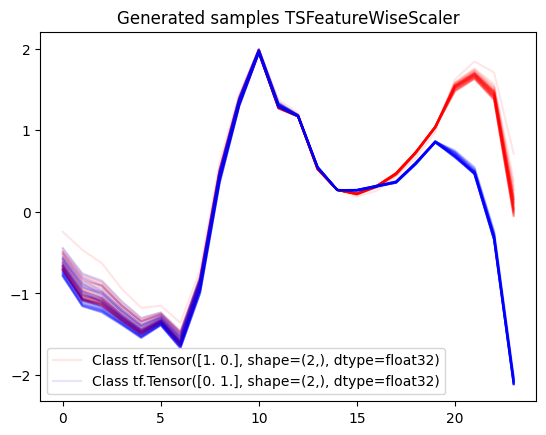

In [29]:
from matplotlib import pyplot as plt

c_to_col = {}
print(gen_data.shape)
for ts,c in zip(gen_data, tensor):
    bool_first = False
    if str(c) not in c_to_col:
        c_to_col[str(c)] = "red" if len(c_to_col) == 0 else "blue"
        bool_first = True
    print(ts)
    plt.plot(ts, alpha=0.1, color=c_to_col[str(c)], label="Class " + str(c) if bool_first else "")

plt.legend()
plt.title("Generated samples TSFeatureWiseScaler")
plt.show()


In [30]:
import tsgm
tsgm.models.zoo.summary()

+-----------------+---------------------------+
|        id       |            type           |
+-----------------+---------------------------+
|    vae_conv5    |     vae:unconditional     |
|    cvae_conv5   |      vae:conditional      |
| cgan_base_c4_l1 |      gan:conditional      |
|    t-cgan_c4    |     gan:t-conditional     |
|   cgan_lstm_n   |      gan:conditional      |
|   cgan_lstm_3   |      gan:conditional      |
|      clf_cn     | downstream:classification |
|     clf_cl_n    | downstream:classification |
|    clf_block    | downstream:classification |
|    recurrent    |      rnn_architecture     |
| clf_transformer | downstream:classification |
+-----------------+---------------------------+
